In [670]:
#import all necessary packages
import math
import numpy as np 
import matplotlib.pyplot as plt


#import the function that we want to be able to use.
from math import sin
from math import cos
from numpy.linalg import inv 
from scipy.integrate import simpson


#### Create a optimal trajectory and an initial guess. 

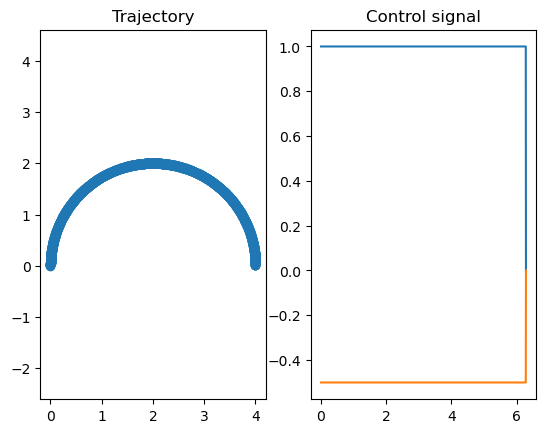

In [671]:
##Initialize our variables and create a reference trajectory--------------------------------------------
tt = 2 * math.pi
timestep = 1000

#Create the time array and unpack the timestep as well.
time,dt = np.linspace(0,tt,timestep, retstep=True)

#Initialize our time step array with 5 state variables at each time step [x_1, x_2, theta, u_1, u_2 ...]
initial_guess = np.zeros(5*time.size)
initial_guess[0:5] = np.array([0,0,math.pi/2,1,-0.5])

#Create our reference trajectory -- make sure that it is scalable to larger sizes
for i in range(0,(len(initial_guess)-5),5):
    #Calculate the intial velocities.
    initial_guess[i + 5] = initial_guess[i] + dt * initial_guess[i + 3] * cos(initial_guess[i + 2])
    initial_guess[i + 6] = initial_guess[i + 1] + dt * initial_guess[i + 3] * sin(initial_guess[i + 2])
    initial_guess[i + 7] = initial_guess[i + 2] + dt * initial_guess[i + 4]
    initial_guess[i + 8] = initial_guess[i + 3]        
    initial_guess[i + 9] = initial_guess[i + 4]    
    
#Set the controls to 0 at the end.
initial_guess[-1], initial_guess[-2] = 0, 0

#Reshape our trajectory to be in the shape we want it to be. 
initial_guess = np.reshape(initial_guess,(time.size,5)).T

##Create an optimal trajectory--------------------------------------------------------------------------
#Initalize our optimal trajectory
optimal = np.array([0,0,math.pi/2]).reshape(3,1)

#Create the optimal trajectory [x_1; x_2]; theta]
for ii in time[1:]:
    optimal = np.hstack((optimal, np.array([(4/(2*math.pi))*ii,0,math.pi/2]).reshape(3,1)))

##Plots-------------------------------------------------------------------------------------------------
fig, axs = plt.subplots(1,2)
#Plotting the reference trajectory
axs[0].scatter(initial_guess[0,:], initial_guess[1,:])
axs[0].axis("equal")
axs[0].set_title("Trajectory")

#Plotting the control signal 
axs[1].plot(time, initial_guess[3,:])
axs[1].set_title("Control signal")
axs[1].plot(time, initial_guess[4,:], "tab:orange")

In [672]:
##Create the difference trajectory for the cost function. 
#Create the initial trajectory of only the states.
initial = initial_guess[0:3,:]

#Find the difference between the two trajectories. 
diff = optimal - initial

#Create the controls for the intial state guess.
initial_controls = initial_guess[3:5,:]

#Create a dictionary of values that places the control and the states of the trajectory at the given timestamp.
#The array needs to be transposed otherwise it creates 5 dictionary values instead of x amount per time. 
state_dict = dict(zip(time,initial_guess.T))
optimal_dict = dict(zip(time,optimal.T))

### Create functions for our most common processes.
To design the controller we construct the objective function so that it can take the error between the two trajectories into account.

In [673]:
##Setup up our constants----------------------------------------------------------------------------
Q = np.diag([1,1,1])

#When r is equal to zero then Q must be equal to P1
P1 = np.diag([1,1,1])

R = np.diag([1,1])

#The terminal condition for r is that it is equal to zero. 
rT = np.zeros((3,))

#The initial condition for z is that it is equal to zero.
z0 = np.zeros((3,))

In [674]:
#Since each of these function are time dependent and will be operating based on changing trajectories, we need them 
#to be able to take in the appopriate dictionary and find the correct A, B, a, or b value based on it. 
def A(t): 
    x, y, theta, u1, u2 = state_dict[t]
    return np.array([[0, 0, -u1 * sin(theta)],
                     [0, 0,  u1 * cos(theta)],
                     [0, 0,         0       ]]) 
                     
def B(t): 
    x, y, theta, u1, u2 = state_dict[t]
    return np.array([[cos(theta), 0],
                     [sin(theta), 0],
                     [   0,       1]]) 

def a(t,Q): 
    state = state_dict[t]
    optimal_state = optimal_dict[t]
    #print(state[0:3,None])
    return 2 * Q @ (state[0:3,None] - optimal_state[:,None])

def b(t,R): 
    state = state_dict[t]
    #print(state[3:5,None])
    return 2 * R @ state[3:5,None] 

#These will be our mathematical functions.
def euler(P1, Q, R, t, dt):
    #Create the P array based on the time size.
    P = np.ndarray((9, t.size))

    #Assign the terminal condition to the end of the array. 
    P[:,-1] = P1.flatten()

    #Find the slope and work backwards using Euler's integration. 
    for i in range(t.size-1, 0, -1):
        #Find the current P matrix that we have and reshape it for matmul.
        cP = P[:,i].reshape(3,3)

        #Find the slope.
        Pdot = cP @ A(t[i]) + A(t[i]).T @ cP - cP @ B(t[i]) @ inv(R) @ B(t[i]).T @ cP + Q

        #Perform Euler's Inegration and update the next step.
        P[:, i-1] = (cP + Pdot * dt).flatten()

    return P

def r_integrate(r0, P, t, dt):
    #Create the r array based on the time size. 
    r = np.ndarray((3,t.size))

    #Assign the terminal condition to the end of the array. 
    r[:,-1] = r0

    #Find the slope and work backwards using Euler's integration. 
    for i in range(t.size-1, 0, -1):
        #Find the current r matrix that we have and reshape it for matmul.
        cr = r[:,i,None]

        #Find the slope.
        rdot = (A(t[i]) - B(t[i]) @ inv(R) @ B(t[i]).T @ P[:,i].reshape(3,3)).T @ cr + a(t[i],Q) - P[:,i].reshape(3,3) @ B(t[i]) @ inv(R) @ b(t[i],R)

        #Perform Euler's Inegration and update the next step.
        r[:, i-1] = (cr + rdot * dt).flatten()
    return r

def z_integrate(z0, P, r, t, dt):
    #Create the z array based on the time size. 
    z = np.ndarray((3,t.size))

    #Assign the intitial condition to the beginning of the array. 
    z[:,0] = z0

    #Find the slope and work forwards using Euler's integration. 
    for i in range(0, t.size-1, 1):
        #Find the current z matrix that we have and reshape it for matmul.
        cz = z[:,i,None]

        #Find the slope.
        zdot = A(t[i]) @ cz + B(t[i]) @ (-1 * inv(R) @ B(t[i]).T @ P[:,i].reshape(3,3) @ cz - inv(R) @ B(t[i]).T @ r[:,i,None] - inv(R) @ b(t[i],R))
        # zdot = A(t[i]) @ cz + B(t[i]) @ (-1 * inv(R) @ B(t[i]).T @ P[:,i].reshape(3,3) @ cz  - inv(R) @ b(t[i],R))

        #Perform Euler's Inegration and update the next step.
        z[:, i+1] = (cz + zdot * dt).flatten()
    return z

def v_integrate(P, r, z, t):
    #Create the z array based on the time size. 
    v = np.ndarray((2,t.size))

    #Find the v values based on the current time step. 
    for i in range(0, t.size, 1):
        #Assign the value of v. 
        v[:, i] = (-1 * inv(R) @ B(t[i]).T @ P[:,i].reshape(3,3) @ z[:,i, None] - inv(R) @ B(t[i]).T @ r[:,i,None] - inv(R) @ b(t[i],R)).flatten()
        # v[:, i] = (-1 * inv(R) @ B(t[i]).T @ P[:,i].reshape(3,3) @ z[:,i, None]  - inv(R) @ b(t[i],R)).flatten()

    return v 

def J(current, desired, u, t, Q, R, P1):
    #Create the integral array
    integral = np.ndarray((t.size))

    #Create the interior of the integral based on the differences between the two trajectories. 
    for i in range(0, t.size, 1):
        diff = current[:,i,None] - desired[:,i, None]
        integral[i] = diff.T @ Q @ diff + u[:,i,None].T @ R @ u[:,i,None]
        
    cost = 0.5 * simpson(integral, t) + (0.5 * (current[:,-1,None] - desired[:,-1, None]).T @ P1 @ (current[:,-1,None] - desired[:,-1, None]))[0,0]
    # cost = 0.5 * simpson(integral, t) + (0.5 * (current[:,-1,None]).T @ P1 @ (current[:,-1,None]))[0,0]

    #Calculate the integral of cost function using the simpson. 
    return cost 

def dJ(current, desired, u, t, z, v, P1):
    #Create the integral array
    integral = np.ndarray((t.size))
    
    for i in range(0, t.size, 1):
        diff = current[:,i,None] - desired[:,i, None]
        integral[i] = diff.T @ Q @ z[:,i,None] + u[:,i,None].T @ R @ v[:,i,None]
    
    dJ = simpson(integral, t) + ((current[:,-1,None] - desired[:,-1, None]).T @ P1 @ z[:,-1,None])[0,0]
    # dJ = simpson(integral, t) + ((current[:,-1,None]).T @ P1 @ z[:,-1,None])[0,0]

    return dJ

In [675]:
#Begin solving the Ricotti Equations. 
P_All = euler(P1, Q, R, time, dt)

#Begin solving for r based on the terminal condition. 
r_All = r_integrate(rT, P_All, time, dt) 

#Begin solving for z based on the initial condtion. Solve for v, once we have z. 
z_All = z_integrate(z0, P_All, r_All, time, dt)
v_All = v_integrate(P_All, r_All, z_All, time)

trajectory = np.copy(initial)
controls = np.copy(initial_controls)

cost = J(trajectory, optimal, controls, time, Q, R, P1)
d_J = dJ(trajectory, optimal, controls, time, z_All, v_All, P1)

In [676]:
##iLQR Algorithm---------------------------------------------------------------------------------------------
#Initialize the constants that we need. 
alpha = 0.4 
beta = 0.7
epsilon = 10 ** -7

#iterators
xi = 1
j = 0 

#Create our changing trajectory.
trajectory = np.copy(initial_guess)
controls = np.copy(initial_controls)

#Create an objective function list. 
ob_Arr = []
obj_Arr = []

while xi > epsilon: 
    #Begin solving the Ricotti Equations. 
    P_All = euler(P1, Q, R, time, dt)

    #Begin solving for r based on the terminal condition. 
    r_All = r_integrate(rT, P_All, time, dt) 

    #Begin solving for z based on the initial condtion. Solve for v, once we have z.
    #This is the optimal descent direction.  
    z_All = z_integrate(z0, P_All, r_All, time, dt)
    v_All = v_integrate(P_All, r_All, z_All, time)

    #Compute the current cost of the trajectory and the directional derivative in the new direction.
    cost = J(trajectory[0:3,:], optimal, controls, time, Q, R, P1)
    d_J = dJ(trajectory[0:3,:], optimal, controls, time, z_All, v_All, P1)

    #Add the current objective.
    obj_Arr.append(cost)

    print("initial cost is:", cost)
    print("intial directional is:", d_J)

    n = 0 
    maxiter = 0
    gamma = beta ** n 

    #Compute the descent direction based on the new direction z, v. 
    while True:
        print("n is:",n)
        #Update the controls
        temp_controls = controls + gamma * v_All

        #Update the trajectory based on the new controls.
        update = np.zeros((3, time.size))

        #Create our trajectory vector with the controls added in. 
        update = np.concatenate((update, temp_controls)).T.flatten()
        update[0:3] = np.array([0,0,math.pi/2])

        #Create our updated trajectory -- make sure that it is scalable to larger sizes
        for ii in range(0,(5 * len(time)-5),5):
            #Calculate the intial velocities.
            update[ii + 5] = update[ii] + dt * update[ii + 3] * cos(update[ii + 2])
            update[ii + 6] = update[ii + 1] + dt * update[ii + 3] * sin(update[ii + 2])
            update[ii + 7] = update[ii + 2] + dt * update[ii + 4]  

        #Reshape our trajectory. 
        update = update.reshape(time.size,5).T

        #Find the cost of the new trajectory. 
        updated_cost = J(update[0:3,:],optimal,temp_controls,time, Q, R, P1)
        ob_Arr.append(updated_cost)
        print("updated_cost is", updated_cost)
        print("condition is:", cost + alpha * gamma * d_J)

        #Break out of the loop if our condition is met or if we have had too many iterations. 
        if updated_cost < cost + alpha * gamma * d_J:
            break 

        maxiter += 1
        if maxiter > 1000:
            break

        #If we don't break out of the loop, we just do it again. 
        n += 1 
        gamma = beta ** n 

    #Exit the loop if we have too many iterations. 
    if maxiter > 1000:
        break
    
    #When we break out of the loop.
    #Update our trajectory and the dictionary so that we can continue iterating. 
    trajectory = np.copy(update)

    #Update our controls based on our new trajectory.
    controls = trajectory[3:5,:]

    #Update the dictionary being called so that the loop can continue iterating.
    state_dict = dict(zip(time,trajectory.T)) 
    
    j += 1
    xi = abs(dJ(trajectory[0:3,:], optimal, controls, time, z_All, v_All, P1))
    print("j is:",j)
        

initial cost is: 25.79005268587695
intial directional is: -57.11423885419322
n is: 0
updated_cost is 61.854231646100715
condition is: 2.944357144199664
n is: 1
updated_cost is 26.52828882235282
condition is: 9.798065806702851
n is: 2
updated_cost is 14.823869567816647
condition is: 14.595661870455082
n is: 3
updated_cost is 13.506335051376311
condition is: 17.953979115081644
j is: 1
initial cost is: 13.506335051376311
intial directional is: -12.15695872803301
n is: 0
updated_cost is 8.696524266542808
condition is: 8.643551560163107
n is: 1
updated_cost is 8.713127121003001
condition is: 10.10238660752707
j is: 2
initial cost is: 8.713127121003001
intial directional is: -3.094689263762061
n is: 0
updated_cost is 8.369153813233352
condition is: 7.475251415498177
n is: 1
updated_cost is 7.910236916521498
condition is: 7.846614127149625
n is: 2
updated_cost is 7.869470712445065
condition is: 8.106568025305638
j is: 3
initial cost is: 7.869470712445065
intial directional is: -0.910555221159

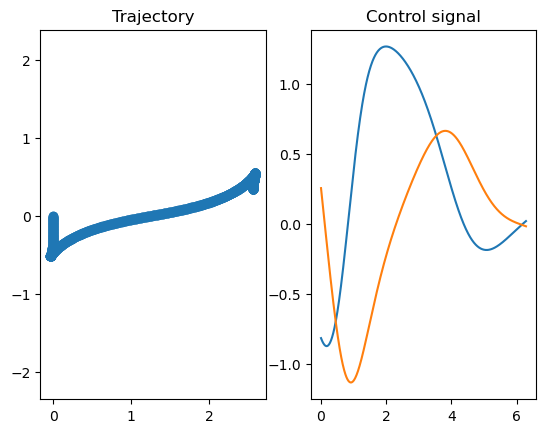

In [677]:
##Plots-------------------------------------------------------------------------------------------------
fig, axs = plt.subplots(1,2)
#Plotting the reference trajectory
axs[0].scatter(trajectory[0,:], trajectory[1,:])
axs[0].axis("equal")
axs[0].set_title("Trajectory")

#Plotting the control signal 
axs[1].plot(time, trajectory[3,:])
axs[1].set_title("Control signal")
axs[1].plot(time, trajectory[4,:], "tab:orange")

Text(0.5, 1.0, 'Objective Overall')

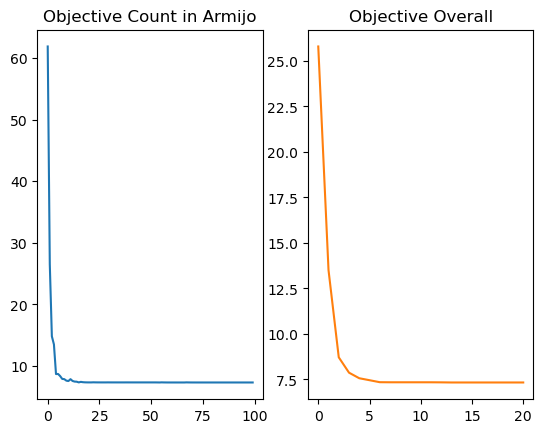

In [678]:
##Plots-------------------------------------------------------------------------------------------------
fig, axs = plt.subplots(1,2)
#Plotting the reference trajectory
axs[0].plot(ob_Arr[0:100])
axs[0].set_title("Objective Count in Armijo")

#Plotting the control signal 
axs[1].plot(obj_Arr, "tab:orange")
axs[1].set_title("Objective Overall")